In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 40000
n_train_neg = 0

n_test_pos = 4000
n_test_neg = 0

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
pair_df.head()

,Unnamed: 0,monomer_id_1,monomer_id_2,amino_seq_1,amino_seq_2,interacts,amino_seq_1_len,amino_seq_2_len
0,0,redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...,TSEENVERQREHVRTTDEAIKEMEKIIRLLEVVARGEMDRDELRKV...,0.0,70,76
1,1,redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...,redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...,SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...,STEEVERIVEEVERISRRVVEISRRVVEKIRELIRRMKNERLVELL...,0.0,68,75
2,2,redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...,redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...,DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...,RTRELLDEHRKLLEEQERQTKQDEELLREVERRLREELIEMAKDVQ...,0.0,76,68
3,3,redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...,redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...,STEDIARELRKIIRRDKESKKEIKRVHDEQRELAKDAEDSRVVRRL...,GKEEVLEVAKRLLELQEKLQRLHEELQRILDDIVRRKNADDTLVRR...,0.0,76,73
4,4,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...,SEKEIIKRLNKLNEDLTRLLETYRRLVEEVERAGALEEELRRRQRE...,SEKEELKRLLEESNKLLELVKEQLRLAEDALRKIAKKARGEVEILE...,0.0,70,77


In [6]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [7]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}

#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))

print("y_train.shape = " + str(y_train.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
y_train.shape = (40000, 1)


In [8]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [9]:
#Calculate background distributions

pseudo_count = 0.1

x_means = []
x_mean_logits = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_mean_logits_len = np.log(x_mean_len)
        
        x_means.append(x_mean_len)
        x_mean_logits.append(x_mean_logits_len)
    else :
        x_means.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))
        x_mean_logits.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))


In [10]:
#Load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [11]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [12]:
mask_1_test = np.expand_dims(np.max(x_1_test, axis=-1), axis=-1)
mask_2_test = np.expand_dims(np.max(x_2_test, axis=-1), axis=-1)

In [13]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [14]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 20))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 20))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 20))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 20))

#Generator helper functions
def initialize_sequence_templates(generator, encoder, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = encoder(sequence_template).reshape((1, len(sequence_template), 20))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['$', '@'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0

        onehot_mask = np.zeros((1, len(sequence_template), 20))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == '$' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 20))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 20), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 20)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [15]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 81
n_samples = 128#32
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=seq_length+1, n_samples=n_samples, sample_mode=sample_mode)


In [16]:
#Load predictor

predictor_path = 'saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5'

predictor = load_model(predictor_path, custom_objects={ 'sigmoid_nll' : lambda y_true, y_pred : y_pred })
predictor.trainable = False
predictor.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=0.1))


In [17]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 20), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

zeropad_layer = Lambda(lambda x: x[0] * x[1], name='zeropad')
sampled_pwm_zeropad = zeropad_layer([sampled_pwm, sampled_mask])

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm_zeropad, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, encoder, sequence_templates, x_mean_logits)

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [18]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dummy_class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
background_dense (Embedding)    (None, 1, 1620)      132840      dummy_class[0][0]                
__________________________________________________________________________________________________
input_logits (InputLayer)       (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 81, 20)    0           background_dense[0][0]           
                                                                 template_dense[0][0]             
          

In [19]:

file_names = [
    "coiled_coil_binders_alyssa_model_inclusion_target_bits_025_epochs_20_kl_divergence_zeropad_gumbel_testset_importance_scores",
    "coiled_coil_binders_alyssa_model_target_bits_24_epochs_20_kl_divergence_zeropad_joint_2_with_label_gumbel_testset_importance_scores",
    "coiled_coil_binders_alyssa_model_target_bits_24_epochs_20_kl_divergence_zeropad_gumbel_testset_importance_scores",
    "perturbation_coiled_coil_binders_zeropad_importance_scores",
    "deepexplain_coiled_coil_binders_method_gradient_importance_scores",
    "deepexplain_coiled_coil_binders_method_integrated_gradients_importance_scores",
    "deepshap_coiled_coil_binders_zeropad_importance_scores",
    "coiled_coil_binders_alyssa_model_inclusion_target_lum_01_epochs_20_kl_divergence_zeropad_gumbel_no_bg_lum_testset_importance_scores",
    "sufficient_input_subsets_coiled_coil_binders_zeropad_thresh_07_importance_scores",
]

file_suffixes = [
    ["_1.npy", "_2.npy"],
    ["_1.npy", "_2.npy"],
    ["_1.npy", "_2.npy"],
    ["_1_test.npy", "_2_test.npy"],
    ["_1_test_signed.npy", "_2_test_signed.npy"],
    ["_1_test_signed.npy", "_2_test_signed.npy"],
    ["_1_test_signed.npy", "_2_test_signed.npy"],
    
    ["_1.npy", "_2.npy"],
    ["_1_test.npy", "_2_test.npy"],
]

model_names =[
    "scrambler_inclusion",
    "scrambler_occlusion_joint",
    "scrambler_occlusion_siamese",
    "perturbation",
    "gradient",
    "integrated_gradients",
    "deepshap",
    
    "zero_scrambler_inclusion",
    "sis_mean",
]

model_signs =[
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    
    1,
    1,
]

model_importance_scores_test = [
    [
        np.load(file_name + file_suffix[0]),
        np.load(file_name + file_suffix[1])
    ] for file_name, file_suffix in zip(file_names, file_suffixes)
]

for model_i in range(len(model_names)) :
    for j in range(len(model_importance_scores_test[model_i])) :
        if len(model_importance_scores_test[model_i][j].shape) == 2 :
            model_importance_scores_test[model_i][j] = np.expand_dims(np.expand_dims(model_importance_scores_test[model_i][j], axis=1), axis=-1)
        
        if model_importance_scores_test[model_i][j].shape[-1] > 1 :
            model_importance_scores_test[model_i][j] = model_signs[model_i] * np.sum(model_importance_scores_test[model_i][j], axis=-1, keepdims=True)

    model_importance_scores_test[model_i][0] *= mask_1_test[:model_importance_scores_test[model_i][0].shape[0]]
    model_importance_scores_test[model_i][1] *= mask_2_test[:model_importance_scores_test[model_i][0].shape[0]]


In [20]:
#Calculate ablation KL divergences (according to model predictions)

feature_quantiles = [0.80, 0.90]

on_state_logit_val = 50.

x_1_test_logits = 2. * x_1_test - 1.
x_2_test_logits = 2. * x_2_test - 1.

y_pred_ref = predictor.predict([x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32, verbose=True)

_, _, _, pwm_mask_1, sampled_mask_1 = scrambler_model.predict([x_1_test_logits, l_1_test], batch_size=batch_size)
_, _, _, pwm_mask_2, sampled_mask_2 = scrambler_model.predict([x_2_test_logits, l_2_test], batch_size=batch_size)

model_ablation_kl_divergences = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_kl_divergences = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        importance_scores_1_test = model_importance_scores_test[model_i][0]
        importance_scores_2_test = model_importance_scores_test[model_i][1]
        
        
        n_to_test = importance_scores_1_test.shape[0] // batch_size * batch_size
        importance_scores_1_test = importance_scores_1_test[:n_to_test]
        importance_scores_2_test = importance_scores_2_test[:n_to_test]
        
        importance_scores_1_test *= np.expand_dims(np.max(pwm_mask_1[:n_to_test], axis=-1), axis=-1)
        importance_scores_2_test *= np.expand_dims(np.max(pwm_mask_2[:n_to_test], axis=-1), axis=-1)

        quantile_vals_1 = np.quantile(importance_scores_1_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals_1 = np.tile(quantile_vals_1, (1, importance_scores_1_test.shape[1], importance_scores_1_test.shape[2], importance_scores_1_test.shape[3]))
        
        quantile_vals_2 = np.quantile(importance_scores_2_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals_2 = np.tile(quantile_vals_2, (1, importance_scores_2_test.shape[1], importance_scores_2_test.shape[2], importance_scores_2_test.shape[3]))

        top_logits_1_test = np.zeros(importance_scores_1_test.shape)
        top_logits_1_test[importance_scores_1_test <= quantile_vals_1] = on_state_logit_val
        
        top_logits_2_test = np.zeros(importance_scores_2_test.shape)
        top_logits_2_test[importance_scores_2_test <= quantile_vals_2] = on_state_logit_val
        
        top_logits_1_test = np.tile(top_logits_1_test, (1, 1, 1, 20)) * x_1_test_logits[:n_to_test]
        top_logits_2_test = np.tile(top_logits_2_test, (1, 1, 1, 20)) * x_2_test_logits[:n_to_test]

        _, _, samples_1_test, _, _ = scrambler_model.predict([top_logits_1_test, l_1_test[:n_to_test]], batch_size=batch_size)
        _, _, samples_2_test, _, _ = scrambler_model.predict([top_logits_2_test, l_2_test[:n_to_test]], batch_size=batch_size)

        mean_kl_divs = []
        for data_ix in range(samples_1_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([samples_1_test[data_ix, :, 0, ...], samples_2_test[data_ix, :, 0, ...]], batch_size=n_samples)[:, 0]
            y_pred_ref_samples = np.tile(y_pred_ref[data_ix, :], (n_samples,))
            
            y_pred_var_samples = np.clip(y_pred_var_samples, 1e-6, 1. - 1e-6)
            y_pred_ref_samples = np.clip(y_pred_ref_samples, 1e-6, 1. - 1e-6)
            
            kl_divs = y_pred_ref_samples * np.log(y_pred_ref_samples / y_pred_var_samples) + (1. - y_pred_ref_samples) * np.log((1. - y_pred_ref_samples) / (1. - y_pred_var_samples))
            
            mean_kl_div = np.mean(kl_divs)

            mean_kl_divs.append(mean_kl_div)

        mean_kl_divs = np.array(mean_kl_divs)
        
        feature_quantile_kl_divergences.append(mean_kl_divs)

    model_ablation_kl_divergences.append(feature_quantile_kl_divergences)


480/480 [==============================] - 3s 7ms/step
Benchmarking model 'scrambler_inclusion'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Benchmarking model 'scrambler_occlusion_joint'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Benchmarking model 'scrambler_occlusion_siamese'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 0.

In [21]:
#Calculate inclusion KL divergences (according to model predictions)

feature_quantiles = [0.80, 0.90]

on_state_logit_val = 50.

x_1_test_logits = 2. * x_1_test - 1.
x_2_test_logits = 2. * x_2_test - 1.

y_pred_ref = predictor.predict([x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32, verbose=True)

_, _, _, pwm_mask_1, sampled_mask_1 = scrambler_model.predict([x_1_test_logits, l_1_test], batch_size=batch_size)
_, _, _, pwm_mask_2, sampled_mask_2 = scrambler_model.predict([x_2_test_logits, l_2_test], batch_size=batch_size)

model_inclusion_kl_divergences = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_kl_divergences = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        importance_scores_1_test = model_importance_scores_test[model_i][0]
        importance_scores_2_test = model_importance_scores_test[model_i][1]
        
        
        n_to_test = importance_scores_1_test.shape[0] // batch_size * batch_size
        importance_scores_1_test = importance_scores_1_test[:n_to_test]
        importance_scores_2_test = importance_scores_2_test[:n_to_test]
        
        importance_scores_1_test *= np.expand_dims(np.max(pwm_mask_1[:n_to_test], axis=-1), axis=-1)
        importance_scores_2_test *= np.expand_dims(np.max(pwm_mask_2[:n_to_test], axis=-1), axis=-1)

        quantile_vals_1 = np.quantile(importance_scores_1_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals_1 = np.tile(quantile_vals_1, (1, importance_scores_1_test.shape[1], importance_scores_1_test.shape[2], importance_scores_1_test.shape[3]))
        
        quantile_vals_2 = np.quantile(importance_scores_2_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals_2 = np.tile(quantile_vals_2, (1, importance_scores_2_test.shape[1], importance_scores_2_test.shape[2], importance_scores_2_test.shape[3]))

        top_logits_1_test = np.zeros(importance_scores_1_test.shape)
        top_logits_1_test[importance_scores_1_test > quantile_vals_1] = on_state_logit_val
        
        top_logits_2_test = np.zeros(importance_scores_2_test.shape)
        top_logits_2_test[importance_scores_2_test > quantile_vals_2] = on_state_logit_val
        
        top_logits_1_test = np.tile(top_logits_1_test, (1, 1, 1, 20)) * x_1_test_logits[:n_to_test]
        top_logits_2_test = np.tile(top_logits_2_test, (1, 1, 1, 20)) * x_2_test_logits[:n_to_test]

        _, _, samples_1_test, _, _ = scrambler_model.predict([top_logits_1_test, l_1_test[:n_to_test]], batch_size=batch_size)
        _, _, samples_2_test, _, _ = scrambler_model.predict([top_logits_2_test, l_2_test[:n_to_test]], batch_size=batch_size)

        mean_kl_divs = []
        for data_ix in range(samples_1_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([samples_1_test[data_ix, :, 0, ...], samples_2_test[data_ix, :, 0, ...]], batch_size=n_samples)[:, 0]
            y_pred_ref_samples = np.tile(y_pred_ref[data_ix, :], (n_samples,))
            
            y_pred_var_samples = np.clip(y_pred_var_samples, 1e-6, 1. - 1e-6)
            y_pred_ref_samples = np.clip(y_pred_ref_samples, 1e-6, 1. - 1e-6)
            
            kl_divs = y_pred_ref_samples * np.log(y_pred_ref_samples / y_pred_var_samples) + (1. - y_pred_ref_samples) * np.log((1. - y_pred_ref_samples) / (1. - y_pred_var_samples))
            
            mean_kl_div = np.mean(kl_divs)

            mean_kl_divs.append(mean_kl_div)

        mean_kl_divs = np.array(mean_kl_divs)
        
        feature_quantile_kl_divergences.append(mean_kl_divs)

    model_inclusion_kl_divergences.append(feature_quantile_kl_divergences)


480/480 [==============================] - 0s 722us/step
Benchmarking model 'scrambler_inclusion'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Benchmarking model 'scrambler_occlusion_joint'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Benchmarking model 'scrambler_occlusion_siamese'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Feature quantile = 0.9
Processing example 

In [22]:
model_names =[
    "scrambler\n(inclusion siamese)",
    "scrambler\n(occlusion joint)",
    "scrambler\n(occlusion siamese)",
    "perturbation",
    "gradient",
    "integrated\ngradients",
    "deepshap",
    "zero scrambler\n(inclusion siamese)",
    "sis (mean)",
]

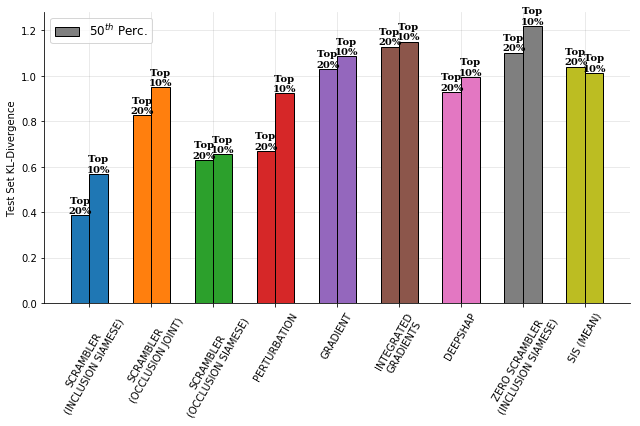

In [23]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(9, 6))

benchmark_name = "benchmark_inclusion_coiled_coil_binders_main_less_signed"

save_figs = True

width = 0.3#0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [1]#[0.4, 0.6, 0.8, 1]

feature_quantiles = [0.80, 0.90]#[0.80, 0.90, 0.95, 0.97]

quantiles = [0.5]#[0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        kl_div_samples = model_inclusion_kl_divergences[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

#plt.xticks([i + 2.5*width for i in range(len(model_names))])
plt.xticks([i + 1.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set KL-Divergence")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


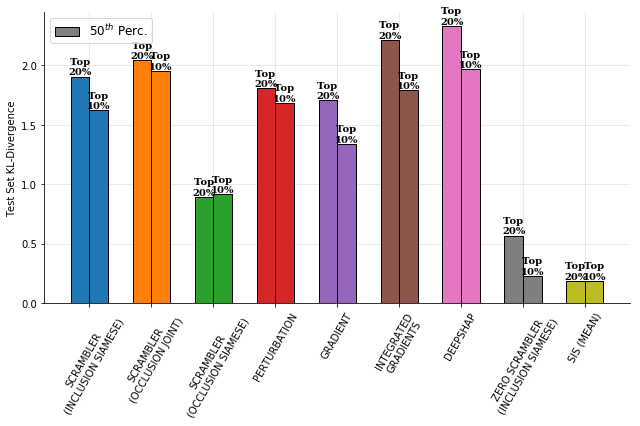

In [24]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(9, 6))

benchmark_name = "benchmark_ablation_coiled_coil_binders_main_less_signed"

save_figs = True

width = 0.3#0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [1]#[0.4, 0.6, 0.8, 1]

feature_quantiles = [0.80, 0.90]#[0.80, 0.90, 0.95, 0.97]

quantiles = [0.5]#[0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        kl_div_samples = model_ablation_kl_divergences[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

#plt.xticks([i + 2.5*width for i in range(len(model_names))])
plt.xticks([i + 1.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set KL-Divergence")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


In [25]:
#HBNet analysis

In [26]:

hbnet_1_test = np.load("HBNet_positions_updated_1.npy")
hbnet_2_test = np.load("HBNet_positions_updated_2.npy")


In [27]:
hbnet_df = pd.read_csv("HBNetPositions_updated_target_bits_24_epochs_20_positive_and_negative_trained.csv", sep=',')

In [28]:
test_df["hbnet_id"] = test_df["monomer_id_1"].apply(lambda x: x[:-2])
test_df["row_ix"] = np.arange(len(test_df))

In [29]:
hbnet_ids = np.array(hbnet_df["structure"].values, dtype=np.object)

In [30]:
keep_index = (test_df.set_index("hbnet_id").loc[hbnet_ids])["row_ix"].values

In [31]:
hbnet_1_test = hbnet_1_test.tolist()
hbnet_1_test = np.concatenate([
    np.array(np.concatenate([
        hbnet_1_test[i],
        np.zeros(81 - len(hbnet_1_test[i]))
    ], axis=0)).reshape(1, -1) for i in range(len(hbnet_1_test))
], axis=0)

hbnet_2_test = hbnet_2_test.tolist()
hbnet_2_test = np.concatenate([
    np.array(np.concatenate([
        hbnet_2_test[i],
        np.zeros(81 - len(hbnet_2_test[i]))
    ], axis=0)).reshape(1, -1) for i in range(len(hbnet_2_test))
], axis=0)


In [32]:

model_flat_importance_scores = []
model_flat_hbnet_positions = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    importance_scores_1_test = model_importance_scores_test[model_i][0]
    importance_scores_2_test = model_importance_scores_test[model_i][1]

    n_to_test = importance_scores_1_test.shape[0]
    keep_index = np.array([k for k in keep_index.tolist() if k < n_to_test], dtype=np.int)
    
    importance_scores_1_test = importance_scores_1_test[keep_index]
    importance_scores_2_test = importance_scores_2_test[keep_index]

    model_flat_importance_scores.append(np.ravel(np.concatenate([
        importance_scores_1_test, importance_scores_2_test
    ], axis=2)))

    model_flat_hbnet_positions.append(np.ravel(np.concatenate([
        hbnet_1_test[:importance_scores_1_test.shape[0]], hbnet_2_test[:importance_scores_2_test.shape[0]]
    ], axis=1)))


Benchmarking model 'scrambler
(inclusion siamese)'...
Benchmarking model 'scrambler
(occlusion joint)'...
Benchmarking model 'scrambler
(occlusion siamese)'...
Benchmarking model 'perturbation'...
Benchmarking model 'gradient'...
Benchmarking model 'integrated
gradients'...
Benchmarking model 'deepshap'...
Benchmarking model 'zero scrambler
(inclusion siamese)'...
Benchmarking model 'sis (mean)'...


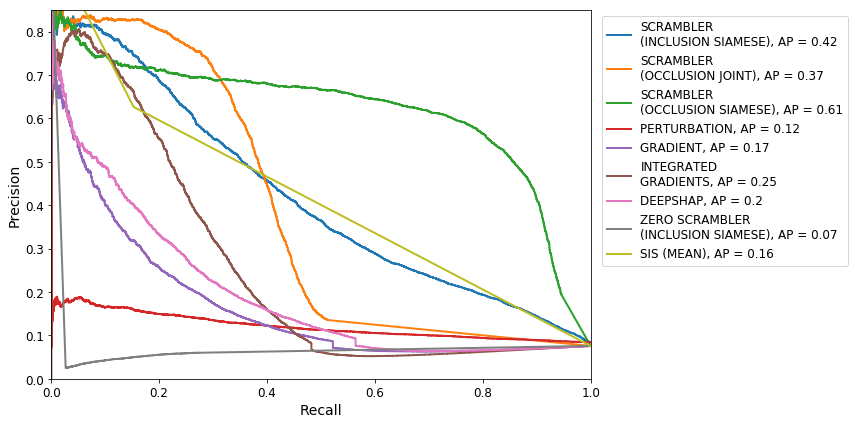

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

benchmark_name = "benchmark_coiled_coil_binders_main_less_signed_hbnet_precision_recall"

save_figs = True

f = plt.figure(figsize=(12, 6))

ls = []

for model_i, model_name in enumerate(model_names) :
    
    precision, recall, thresholds = precision_recall_curve(model_flat_hbnet_positions[model_i], model_flat_importance_scores[model_i])

    ap = average_precision_score(model_flat_hbnet_positions[model_i], model_flat_importance_scores[model_i])
    ap = str(round(ap, 2))[:4]
    
    l1, = plt.plot(recall, precision, linewidth=2, label=model_name.upper() + ", AP = " + str(ap))
    ls.append(l1)
    
    plt.plot()

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0, 1)
plt.ylim(0, 0.85)

plt.legend(handles=ls, fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


In [34]:
#Stability/Energy Analysis

stability_df = pd.read_csv("permutation_test_values_12_11_20.csv", sep=",")


In [35]:
stability_df = stability_df.set_index("Model")

In [36]:
#Selected benchmarked methods

subset_df = stability_df.loc[[
    "inclusion_tb_025_ep_20_gumbel",
    "occlusion_target_bits_24_epochs_20_kl_divergence_zeropad_joint_2_with_label_gumbel",
    "occlusion_target_bits_24_epochs_20_kl_divergence_zeropad_gumbel",
    "perturbation_zeropad",
    "deepexplain_coiled_coil_binders_method_gradient_importance_scores_test_signed",
    "deepexplain_coiled_coil_binders_method_integrated_gradients_importance_scores_test_signed",
    "deepshap_coiled_coil_binders_zeropad_importance_scores_test_signed",
    "inclusion_target_lum_01_epochs_20_kl_divergence_zeropad_gumbel_no_bg_lum",
    "sufficient_input_subsets_coiled_coil_binders_zeropad_thresh_07_mean",
]].copy().reset_index()


In [37]:
subset_df

,Model,Unnamed: 0,DimerN,ddGMean,ddGPValue,HBondMeanDifference,HBondPValue,HBondUnsatMeanDiff,HBondUnsatPValue,HBondEnFractionMeanDiff,HBondEnFractionPValue
0,inclusion_tb_025_ep_20_gumbel,24,480,1.701292,0.0001,-0.752476,1.0000,0.316003,0.0001,-0.007846,1.00000
1,occlusion_target_bits_24_epochs_20_kl_divergen...,10,480,2.199685,0.0001,-0.877847,1.0000,0.232239,0.0001,-0.008924,1.00000
2,occlusion_target_bits_24_epochs_20_kl_divergen...,8,480,0.899157,0.0001,-0.937089,1.0000,0.315728,0.0001,-0.011452,1.00000
3,perturbation_zeropad,43,480,1.736259,0.0001,-0.197259,1.0000,0.116787,0.0001,-0.000150,0.89771
4,deepexplain_coiled_coil_binders_method_gradien...,47,480,0.804255,0.0001,-0.327590,1.0000,0.137177,0.0001,-0.003319,1.00000
5,deepexplain_coiled_coil_binders_method_integra...,48,480,1.243216,0.0001,-0.515510,1.0000,0.219564,0.0001,-0.005259,1.00000
6,deepshap_coiled_coil_binders_zeropad_importanc...,49,480,1.010875,0.0001,-0.393996,1.0000,0.170793,0.0001,-0.003896,1.00000
7,inclusion_target_lum_01_epochs_20_kl_divergenc...,4,480,0.730021,0.0001,0.127329,0.0001,-0.057080,1.0000,0.002883,0.00010
8,sufficient_input_subsets_coiled_coil_binders_z...,19,480,0.441169,0.0001,-0.358451,1.0000,0.145443,0.0001,-0.004349,1.00000


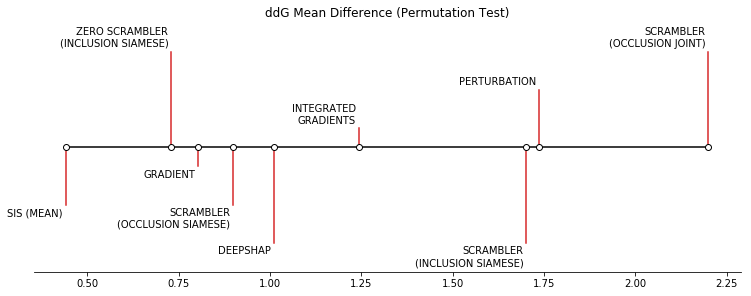

In [38]:
#Plot ddGMean values

model_measures = subset_df["ddGMean"].values.tolist()

benchmark_name = "benchmark_coiled_coil_binders_main_less_signed_ddGMean"

save_figs = True

levels = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(model_names)/6)))[:len(model_names)]

# Create figure and plot a stem plot with the date

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title="ddG Mean Difference (Permutation Test)")

markerline, stemline, baseline = ax.stem(model_measures, levels,
                                         linefmt="C3-", basefmt="k-")

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(model_measures)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for m, l, r, va in zip(model_measures, levels, model_names, vert):
    ax.annotate(r.upper(), xy=(m, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.15)

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


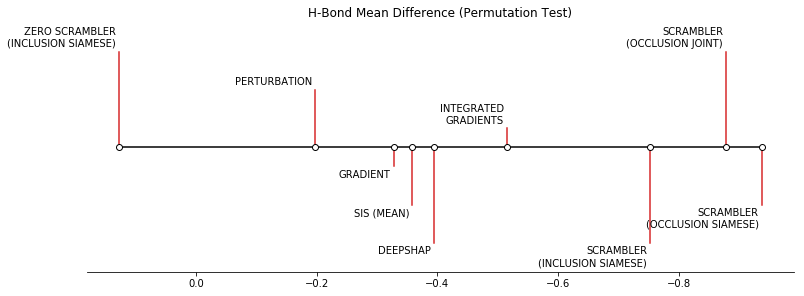

In [39]:
#Plot ddGMean values

model_measures = subset_df["HBondMeanDifference"].values.tolist()

benchmark_name = "benchmark_coiled_coil_binders_main_less_signed_HBondMeanDifference"

save_figs = True

levels = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(model_names)/6)))[:len(model_names)]

# Create figure and plot a stem plot with the date

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title="H-Bond Mean Difference (Permutation Test)")

markerline, stemline, baseline = ax.stem(model_measures, levels,
                                         linefmt="C3-", basefmt="k-")

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(model_measures)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for m, l, r, va in zip(model_measures, levels, model_names, vert):
    ax.annotate(r.upper(), xy=(m, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.15)

# invert x-axis
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


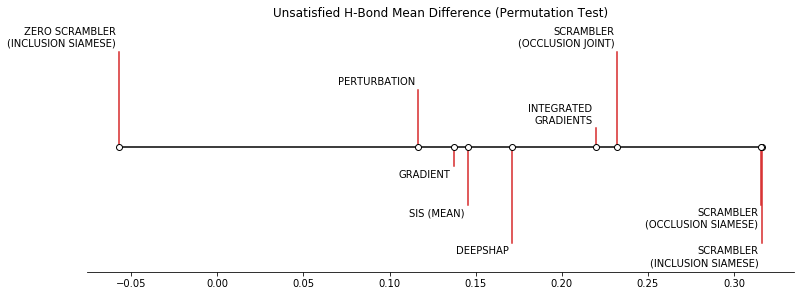

In [40]:
#Plot ddGMean values

model_measures = subset_df["HBondUnsatMeanDiff"].values.tolist()

benchmark_name = "benchmark_coiled_coil_binders_main_less_signed_HBondUnsatMeanDiff"

save_figs = True

levels = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(model_names)/6)))[:len(model_names)]

# Create figure and plot a stem plot with the date

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title="Unsatisfied H-Bond Mean Difference (Permutation Test)")

markerline, stemline, baseline = ax.stem(model_measures, levels,
                                         linefmt="C3-", basefmt="k-")

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(model_measures)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for m, l, r, va in zip(model_measures, levels, model_names, vert):
    ax.annotate(r.upper(), xy=(m, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.15)

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()
